In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
import tracemalloc


# from importlib import reload

In [2]:
import dask
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=10,processes=False,memory_limit='50gb',threads_per_worker=1,memory_spill_fraction=.99,)
#                memory_monitor_interval='2000ms',worker_memory_limit='50gb')
client=Client(LC)
# dask.config.set(scheduler='single-threaded')

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
client

Client Scheduler: inproc://136.152.250.206/31934/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [4]:
client.restart()

Client Scheduler: inproc://136.152.250.206/31934/1 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 10 Memory: 500.00 GB


In [5]:
from cov_3X2 import *
# from fisher import *

In [6]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [7]:
from lsst_utils import *

In [8]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import window_utils
reload(window_utils)
from window_utils import *

In [10]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [11]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [12]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'Ase9': 1.685,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166457654738

In [13]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [14]:
use_window=True
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
Tri_cov=False
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [15]:
f_sky=.7 #3000./(4*np.pi/d2r**2)
f_sky

nside=128

In [16]:
f_sky

0.7

In [17]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,use_window=use_window,f_sky=f_sky,window_cl_fact=0,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),sigma_gamma=sigma_gamma,
                        zp_sigma=z_sigma*np.ones_like(z),nside=nside)

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=1 # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),window_cl_fact=0,
                        zp_sigma=z_sigma*np.ones_like(z),k_max=1.e6,nside=nside)
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Win gen: step size 513
cl dict done


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Win gen: step size 513
cl dict done
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [18]:
for a in ()+("X",):
    print (a)

X


In [19]:
do_cov=True

In [20]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [21]:
#Hankel Transform setup
l_max=1e3
l_maxW=1e3
l_min=2
# nl=1e2
# nl_bins=np.int(nl/10)
# l0=np.logspace(np.log10(l_min),np.log10(l_maxW),nl)
# l0=np.append([0,1],l0)
# l0=np.unique(np.int32(l0))
# l0_HT=l0
l0=np.arange(l_min,l_max)
l0_HT=np.arange(l_max)
nl_bins=20
  #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
# l_bins=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),50)))
l_bins=np.unique(np.int32(np.linspace(l_min,l_max,nl_bins)))
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [22]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [23]:
corr_ggl=('shear','galaxy')
corr_ggk=('kappa','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
corr_kk=('kappa','kappa')
m1m2=(0,2)
m1m2_gg=(0,0)

In [24]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0_HT,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

./wigner_functions.py:38: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:38: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


CPU times: user 418 ms, sys: 931 ms, total: 1.35 s
Wall time: 2.2 s


In [25]:
window_lmax=30
bi=(0,0)



In [26]:
import window_utils
reload(window_utils)
from window_utils import *

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [27]:
np.int8(1)

1

In [28]:
do_cov=True
use_window=True

In [29]:
[j for j in itertools.combinations_with_replacement([0,2],2)]

[(0, 0), (0, 2), (2, 2)]

In [30]:
tracemalloc.clear_traces()
tracemalloc.start()

t1=time.time()
try:
    Win=XI_W_L.Win.Win
except:
    Win=None
XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_gg,corr_ggl]
                ,store_win=False,Win=Win,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
t2=time.time()
snapshot1 = tracemalloc.take_snapshot()
print('W done',t2-t1)
top_stats = snapshot1.statistics('lineno')

Win gen: step size 1001
wigner_files: {0: 'temp/dask_wig3j_l6500_w1100_0_reorder.zarr', 2: 'temp/dask_wig3j_l6500_w1100_2_reorder.zarr'}
wigner done dict_keys([0, 2])
setting windows None
W done 0.12971973419189453


In [31]:
top_stats = snapshot1.statistics('traceback')

In [32]:
tracemalloc.get_traced_memory()

(75304498, 75383548)

In [33]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

34 memory blocks: 62.5 MiB
  File "/usr/lib/python3.7/site-packages/numpy/core/einsumfunc.py", line 1346
    return c_einsum(*operands, **kwargs)


In [34]:
top_stats

[<Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/einsumfunc.py' lineno=1346>,)> size=65524208 count=34>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/numeric.py' lineno=1203>,)> size=8000080 count=2>,
 <Statistic traceback=<Traceback (<Frame filename='./binning.py' lineno=19>,)> size=1111808 count=16>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/lib/function_base.py' lineno=792>,)> size=59088 count=38>,
 <Statistic traceback=<Traceback (<Frame filename='./binning.py' lineno=30>,)> size=56440 count=12>,
 <Statistic traceback=<Traceback (<Frame filename='./binning.py' lineno=14>,)> size=56440 count=12>,
 <Statistic traceback=<Traceback (<Frame filename='/usr/lib/python3.7/site-packages/numpy/core/function_base.py' lineno=279>,)> size=40160 count=3>,
 <Statistic traceback=<Traceback (<Frame filename='./tracer_utils.py' lineno=71>,)> size=16256 count

In [35]:
%time clG=XI_W_L.cl_tomo()

added extra corr calc for covariance [('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 4.39 s, sys: 108 ms, total: 4.49 s
Wall time: 707 ms


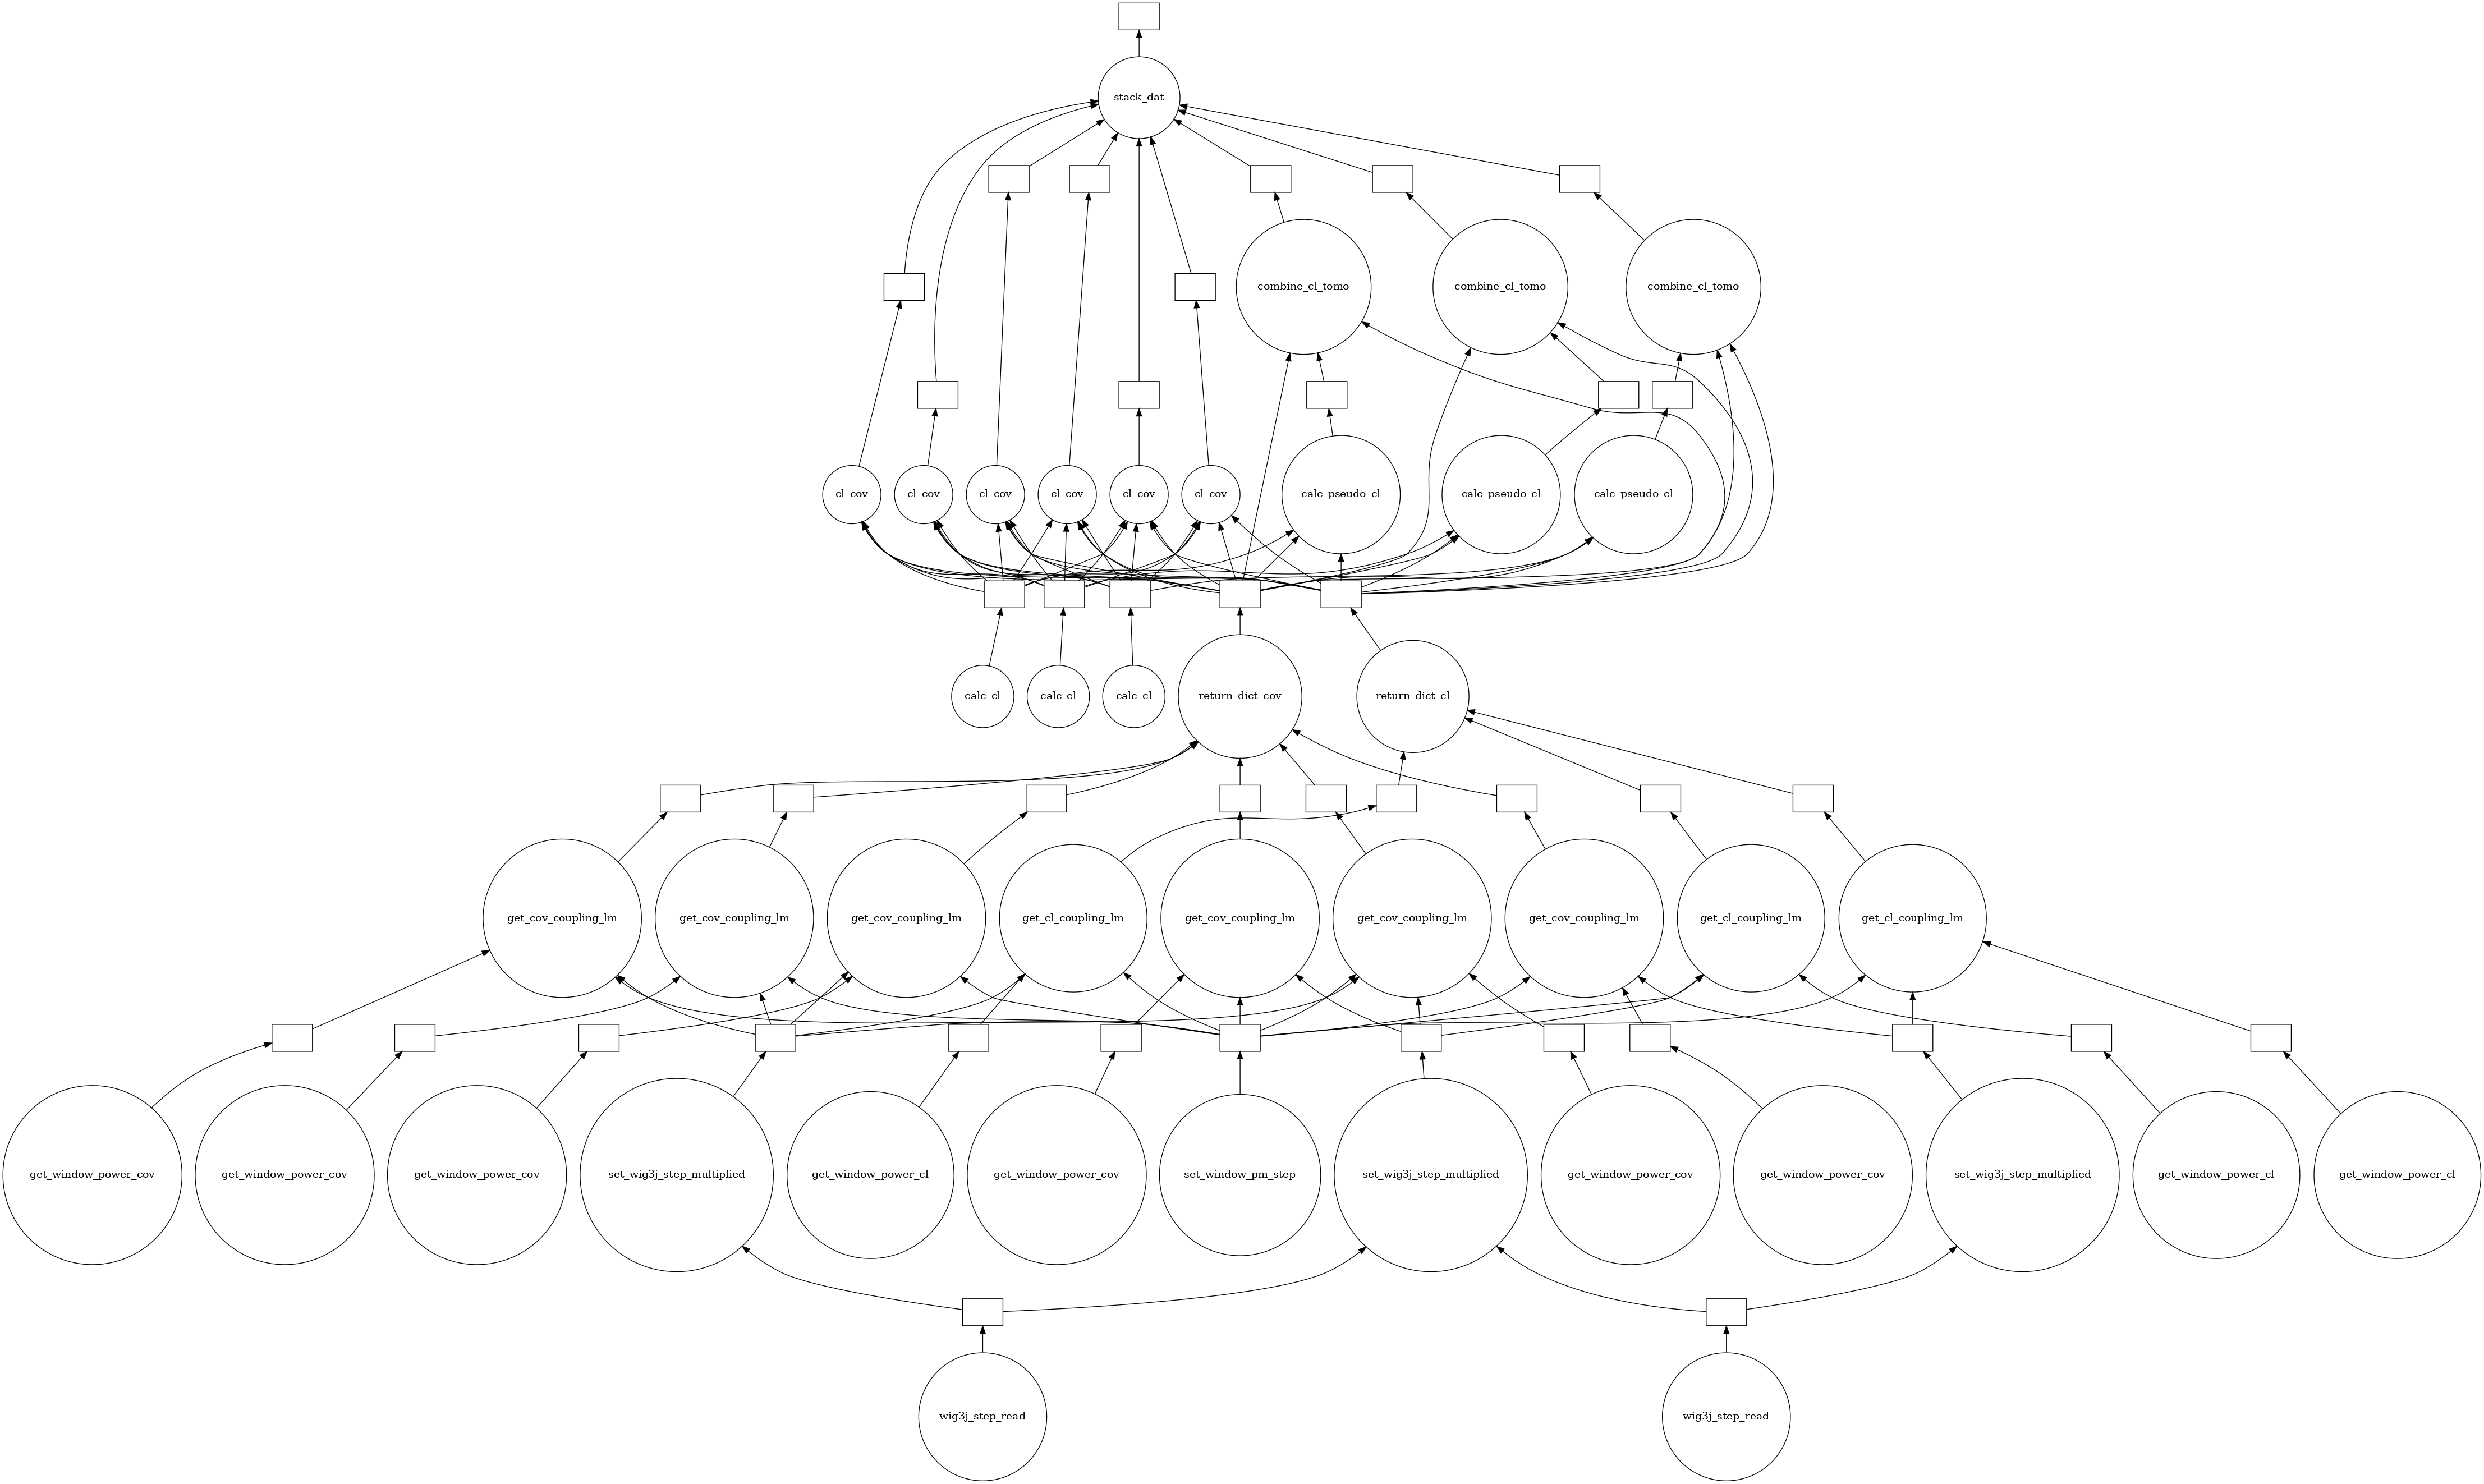

In [36]:
clG['stack'].visualize()

In [37]:
%time cl_L=clG['stack'].compute()

CPU times: user 8.95 s, sys: 1.61 s, total: 10.6 s
Wall time: 3.28 s


In [38]:
cl=clG['cl'][corr_ll][bi].compute()
pcl=clG['cl_b'][corr_ll][bi].compute()

In [39]:
lb=0.5*(XI_W_L.l_bins[1:]+XI_W_L.l_bins[:-1])

[]

09:59:58 WARNING:findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


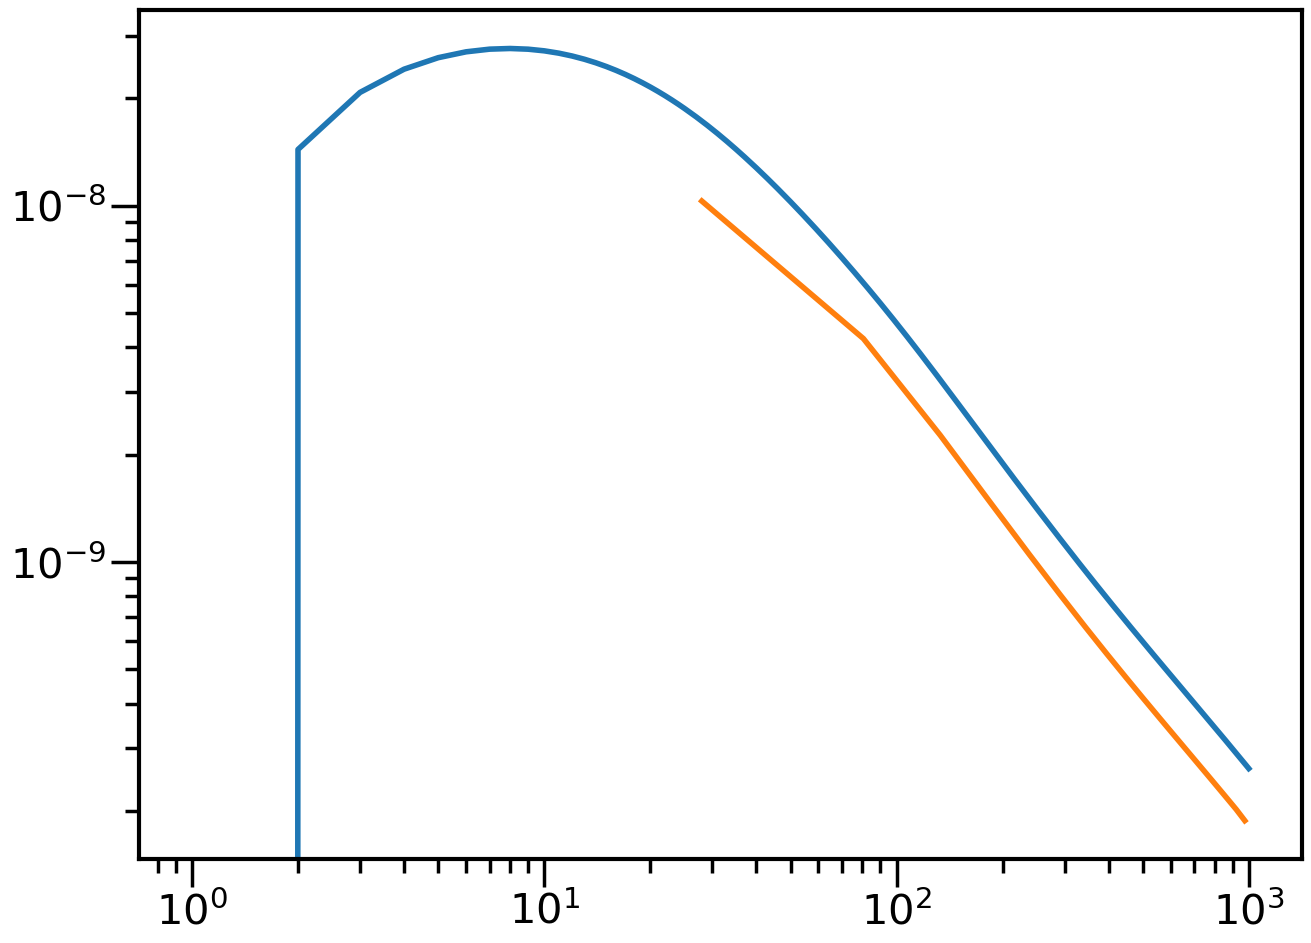

In [40]:
plot(XI_W_L.l,cl)
plot(lb,pcl)
loglog()

In [41]:
A=np.int8(np.eye(1000))
X=np.float32(np.eye(1000))

In [42]:
A

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [43]:
B=A.astype('bool')

In [44]:
%time x1=X*A
%time x2=X*B

CPU times: user 2.38 ms, sys: 213 µs, total: 2.59 ms
Wall time: 1.16 ms
CPU times: user 493 µs, sys: 2.08 ms, total: 2.58 ms
Wall time: 1.29 ms


In [45]:
np.all(x1==x2)

True

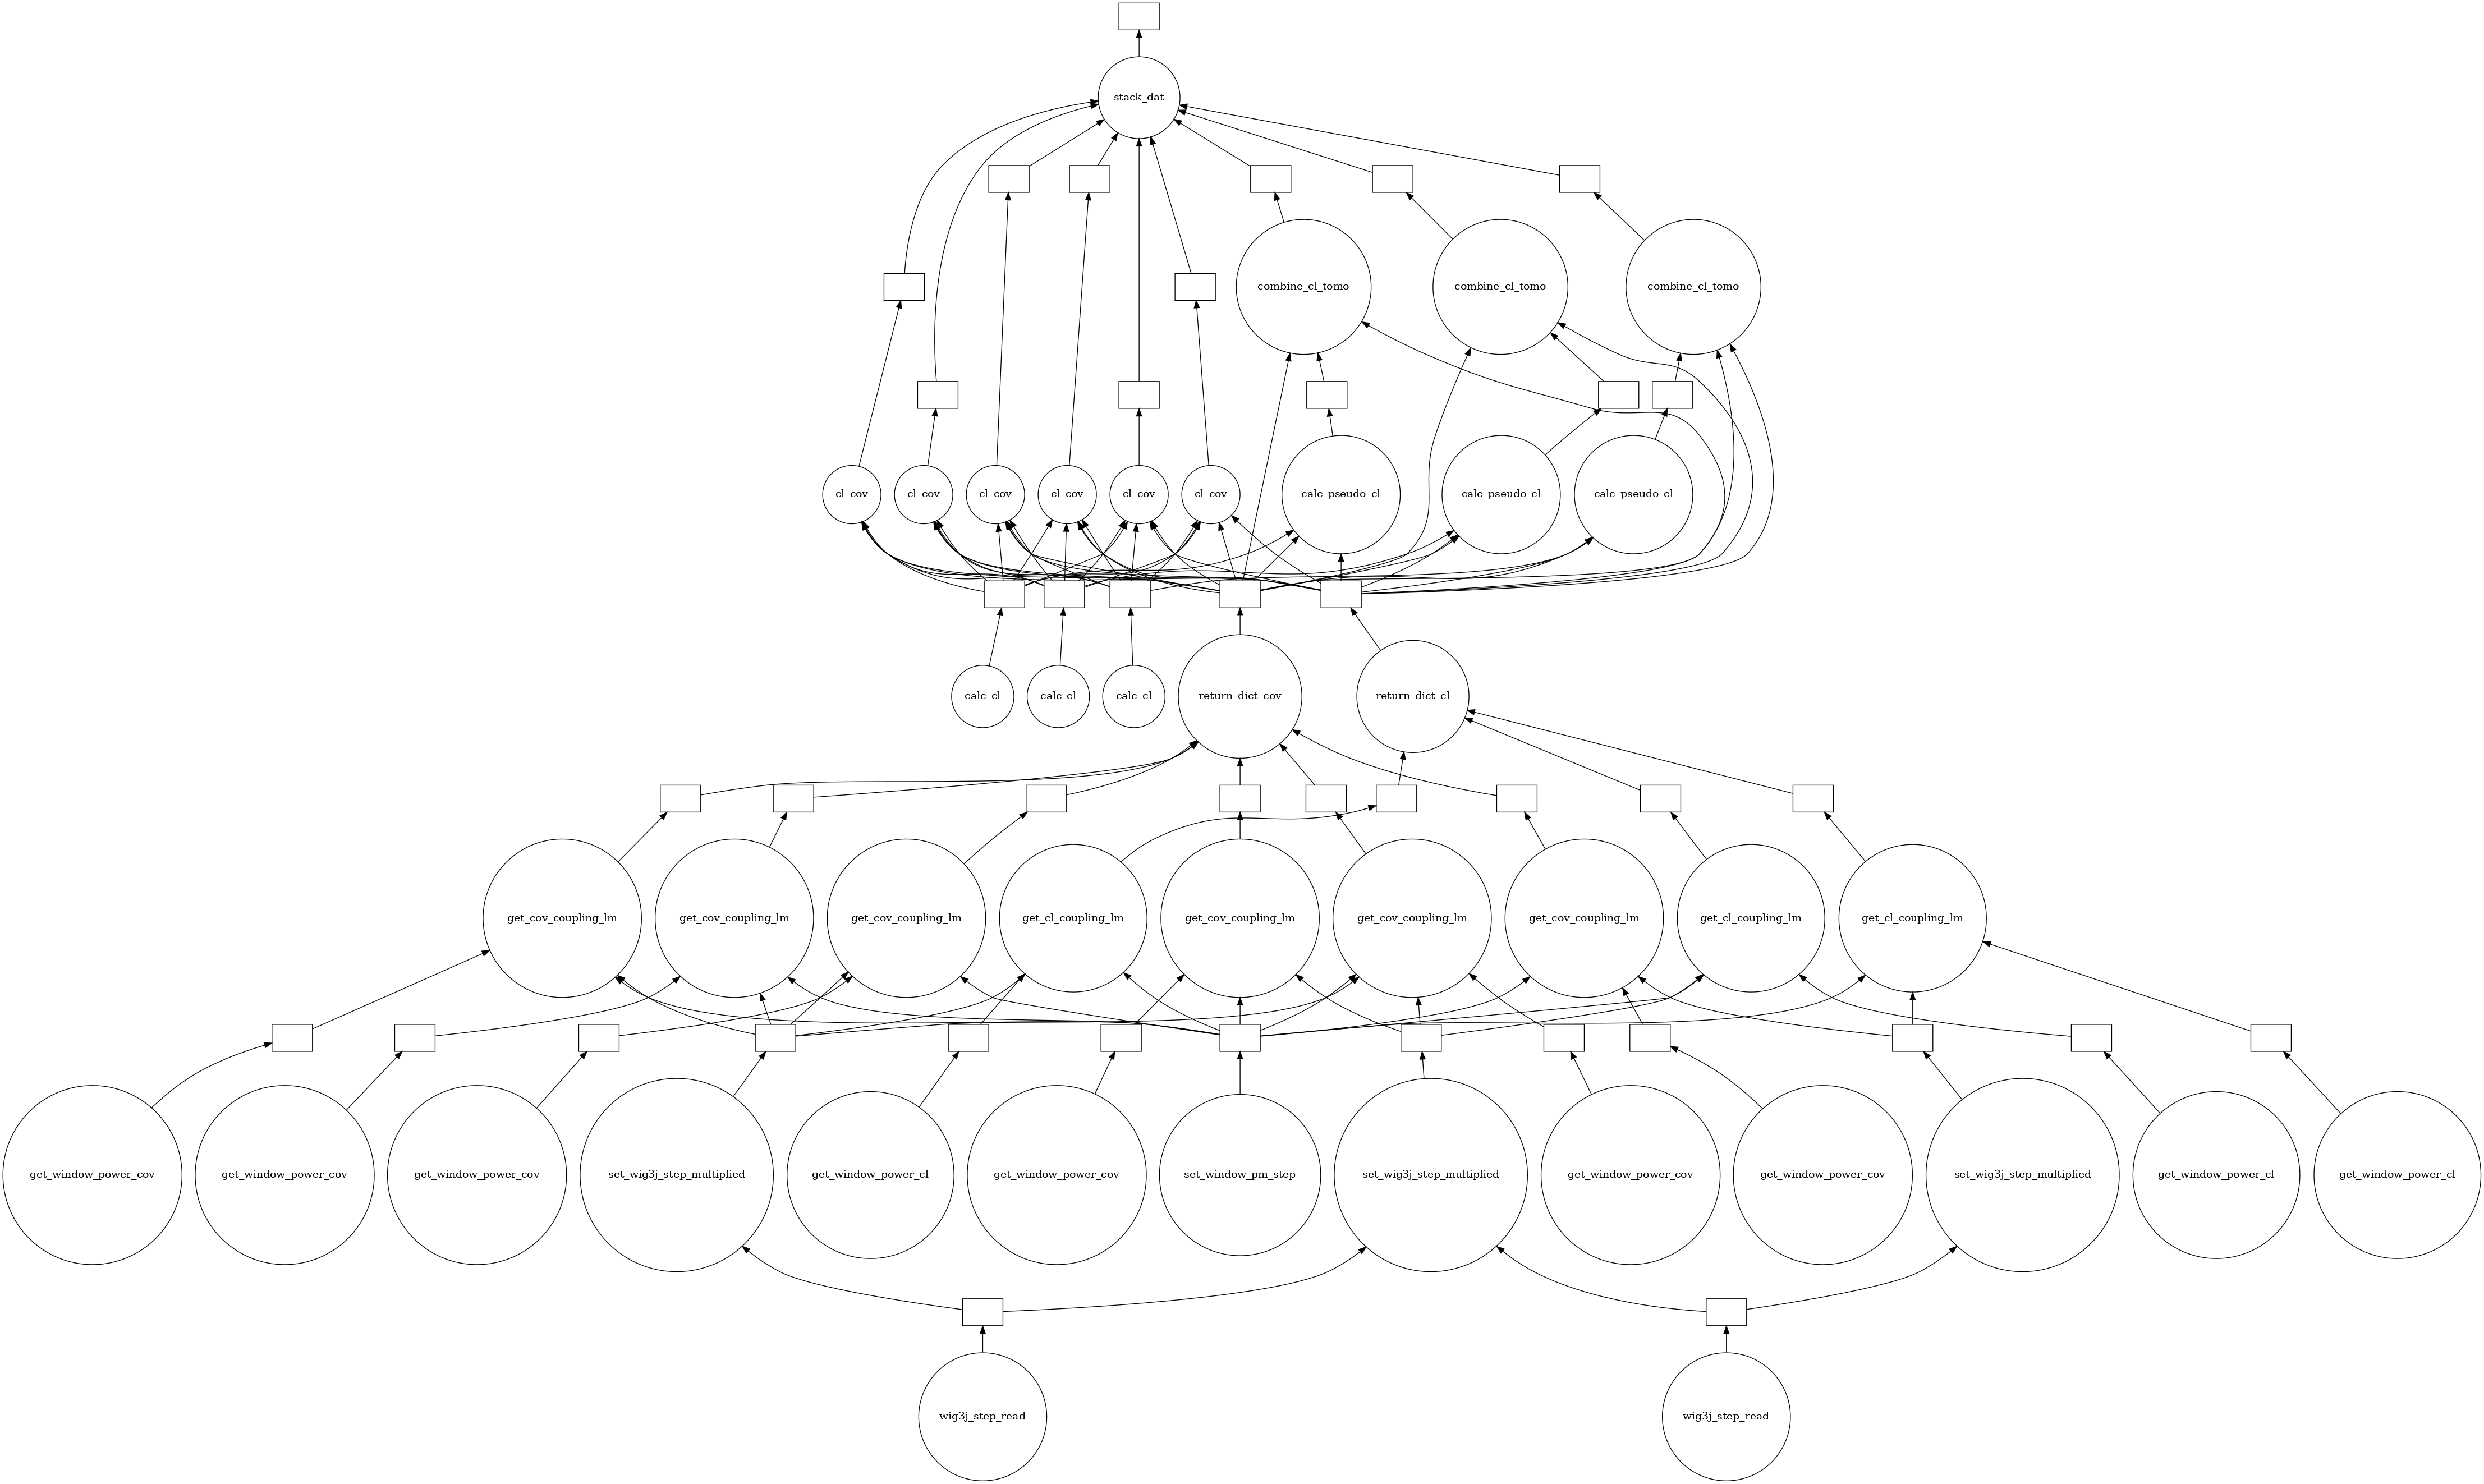

In [46]:
dask.visualize(clG['stack'])

In [47]:
np.arange(1000,step=300)

array([  0, 300, 600, 900])

In [48]:
XI_W_L.Win.Win['cl'][corr_ll][bi]

Delayed('getitem-15e41f5cc69e95ef92946d9b7aab55c7')

In [49]:
XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B']

Delayed('getitem-eff658603410a54eb7d8b8c93a5a5fd6')

In [50]:
# M2=XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2].compute()
try:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B'].compute()
except:
    M2n=XI_W_L.Win.Win['cl'][corr_ll][bi]['M_B']
XI_W_L.SN[corr_ll][:,0,0]@M2n

array([0.00000000e+00, 0.00000000e+00, 3.88874976e-11, 2.73319968e-11,
       1.96765684e-11, 1.61590855e-11, 1.34835982e-11, 1.14336259e-11,
       1.00776349e-11, 8.88522097e-12, 7.94733973e-12, 7.21816568e-12,
       6.54965977e-12, 6.01504963e-12, 5.55394027e-12, 5.13191540e-12,
       4.78484851e-12, 4.46552070e-12, 4.17827693e-12, 3.93220972e-12,
       3.69873319e-12, 3.49192460e-12, 3.30642699e-12, 3.12967581e-12,
       2.97361703e-12, 2.82787023e-12, 2.69062167e-12, 2.56797477e-12,
       2.45037987e-12, 2.34142210e-12, 2.24171879e-12, 2.14524487e-12,
       2.05248328e-12, 1.96370962e-12, 1.87904315e-12, 1.79849449e-12,
       1.72199999e-12, 1.64944643e-12, 1.58068868e-12, 1.51556224e-12,
       1.45389230e-12, 1.39550015e-12, 1.34020753e-12, 1.28783971e-12,
       1.23822761e-12, 1.19120902e-12, 1.14662942e-12, 1.10434235e-12,
       1.06420951e-12, 1.02610082e-12, 9.89894047e-13, 9.55474667e-13,
       9.22735428e-13, 8.91576027e-13, 8.61902727e-13, 8.33627939e-13,
      

[]

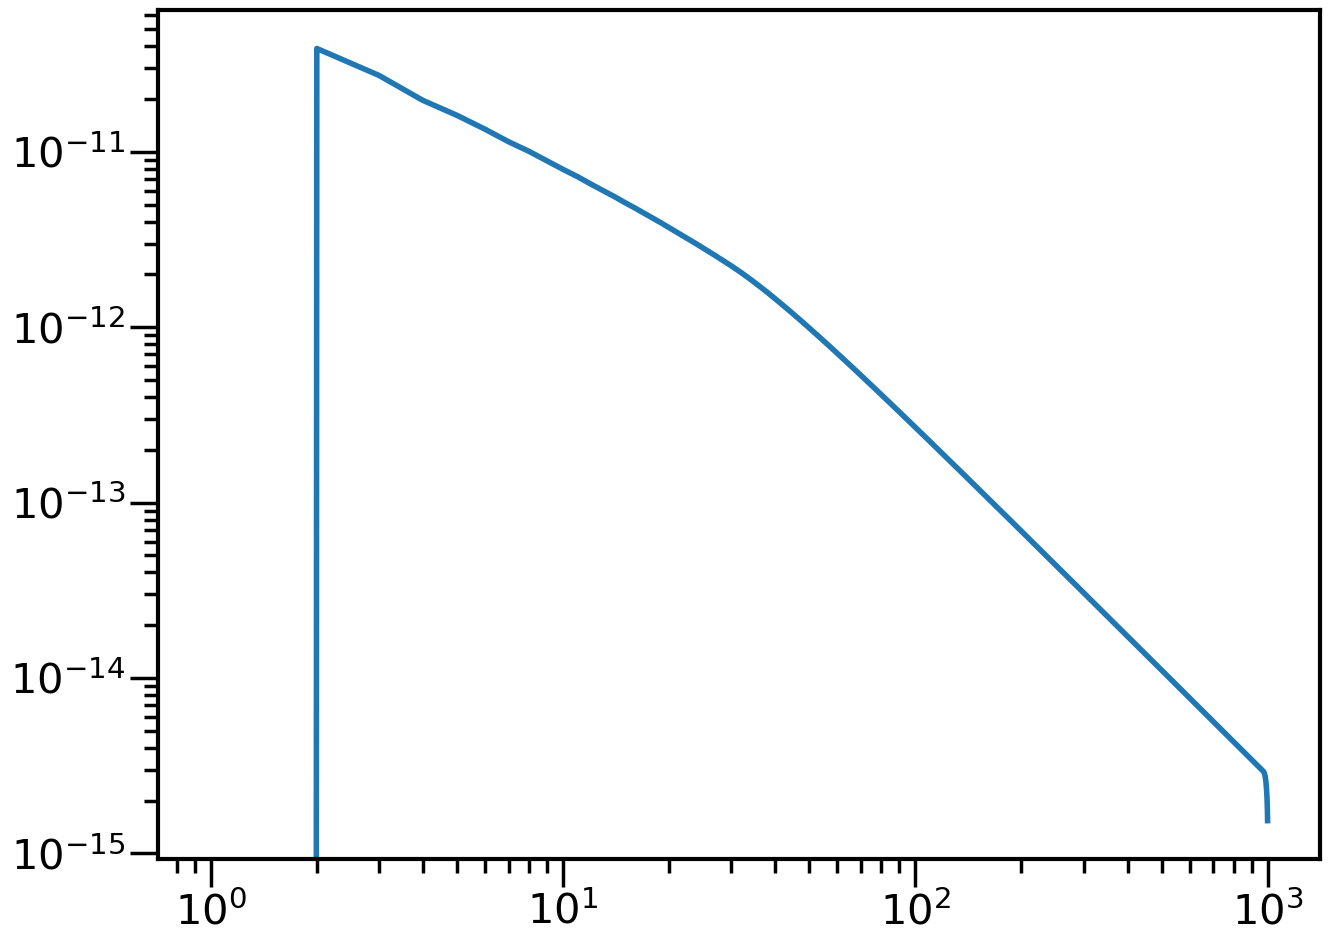

In [51]:
bi=(0,0)
f=1#XI_W_L.l**2
# plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['M1324'][2]))
plot(XI_W_L.l,f*(XI_W_L.SN[corr_ll][:,0,0]@M2n))
loglog()

In [52]:
xx=np.random.uniform(0,1,size=(1000,100,3000,)).astype('float64')
xx2=xx.reshape(100,3000,1000)
xx3=xx2.astype('int8')
A=np.ones(1000)

In [53]:
A2=np.int32(A)

In [54]:
np.__config__.show() 

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
  NOT AVAILABLE
atlas_3_10_blas_threads_info:
  NOT AVAILABLE
atlas_3_10_blas_info:
  NOT AVAILABLE
atlas_blas_threads_info:
  NOT AVAILABLE
atlas_blas_info:
  NOT AVAILABLE
accelerate_info:
  NOT AVAILABLE
blas_info:
    libraries = ['cblas', 'blas']
    library_dirs = ['/usr/lib64']
    include_dirs = ['/usr/local/include', '/usr/include']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    define_macros = [('NO_ATLAS_INFO', 1), ('HAVE_CBLAS', None)]
    libraries = ['cblas', 'blas']
    library_dirs = ['/usr/lib64']
    include_dirs = ['/usr/local/include', '/usr/include']
    language = c
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
  NOT AVAILABLE
openblas_clapack_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE
atlas_threads_info:
  NOT AVAILABLE
atlas_info:
  NOT AVAILABLE
lapack_info:
    libraries = ['lapack', 'lapack']
  

In [55]:
np.__version__

'1.16.4'

In [57]:
XI_W_L_NW= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins, #no window
                do_sample_variance=do_sample_variance,use_window=False,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],store_win=True,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)
print('NW done')

Win gen: step size 1001
NW done


./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


In [58]:
# %time clG=XI_W_L.cl_tomo()
%time clG_nw=XI_W_L_NW.cl_tomo()
#%time clH=XI_H.cl_tomo()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 3.33 s, sys: 32.7 ms, total: 3.36 s
Wall time: 684 ms


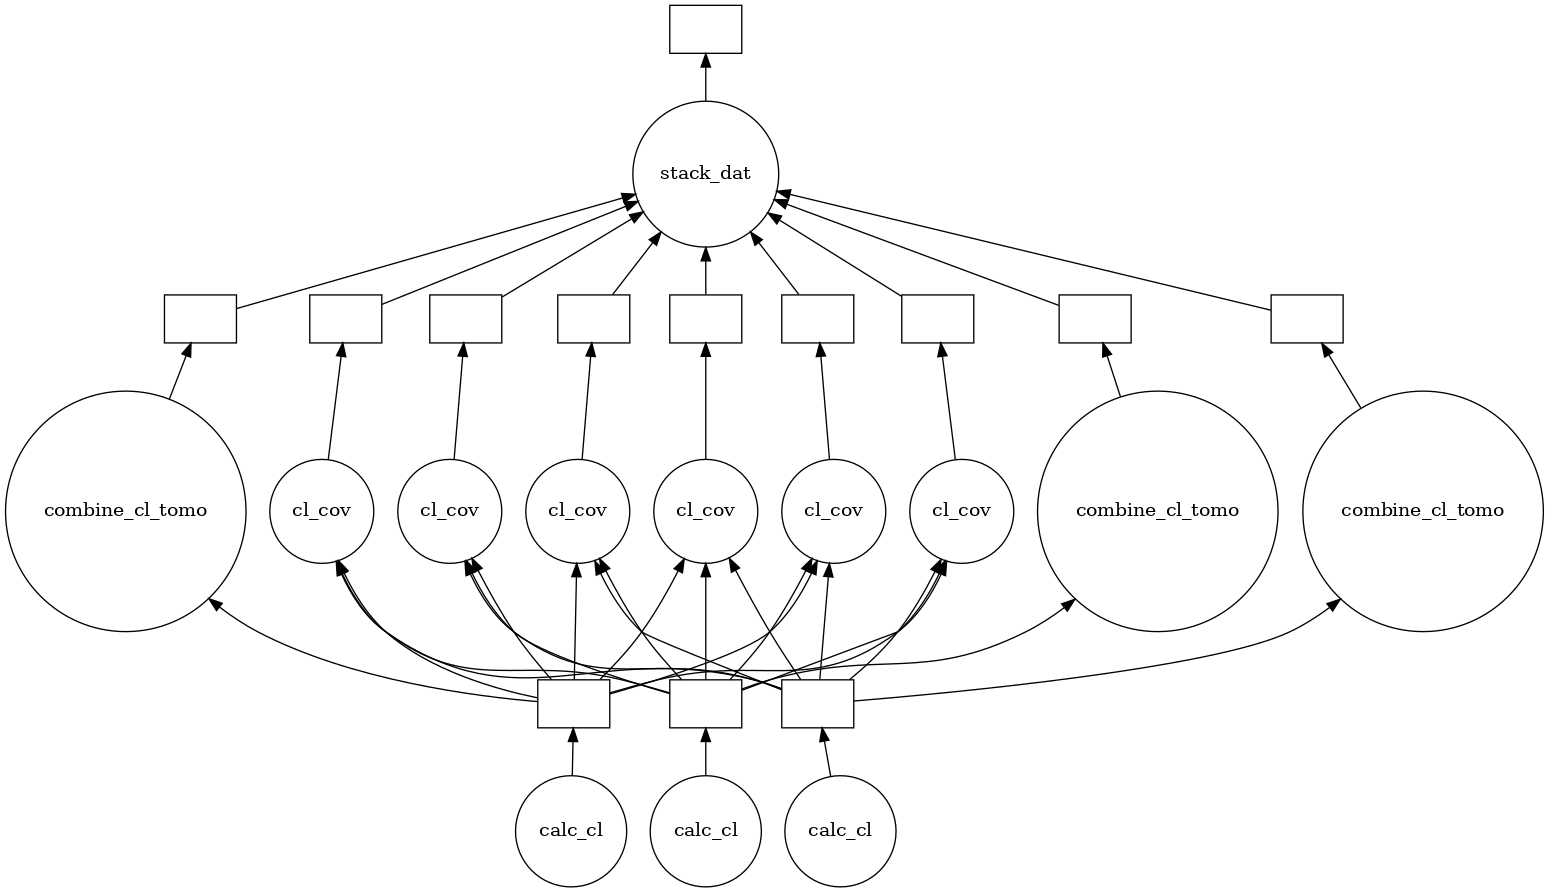

In [59]:
clG_nw['stack'].visualize()

In [60]:
%time cl_L_nw=clG_nw['stack'].compute()

CPU times: user 517 ms, sys: 27.7 ms, total: 545 ms
Wall time: 226 ms


In [61]:
clG['cl'].keys()

dict_keys([('shear', 'shear'), ('galaxy', 'galaxy'), ('shear', 'galaxy'), ('galaxy', 'shear')])

In [62]:
bi=(0,0)
corr=corr_ll
cov_t=clG['cov'][corr+corr][(0,0,0,0)].compute()
cl_bt=clG['cl_b'][corr][(0,0)].compute()
cl_btnw=clG_nw['cl_b'][corr][(0,0)].compute()
cov_tnw=clG_nw['cov'][corr+corr][(0,0,0,0)].compute()

In [63]:
np.sqrt(cov_tnw['SSC_b']/cov_t['SSC_b'])

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan

[]

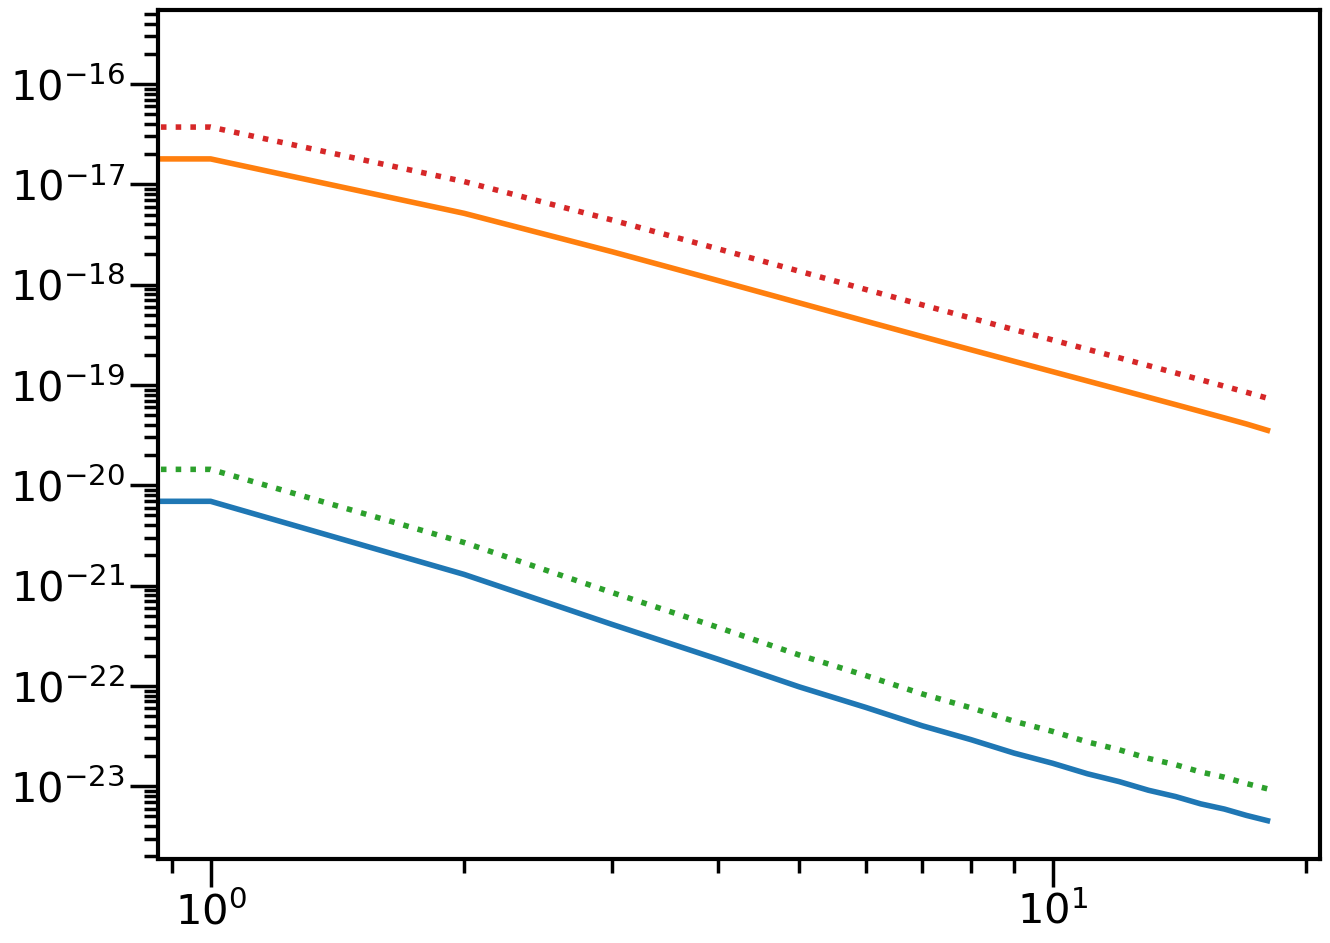

In [64]:
plot(np.diag(cov_t['final_b']))
plot(cl_bt**2)
plot(np.diag(cov_tnw['final_b']),':')
plot(cl_btnw**2,':')
loglog()

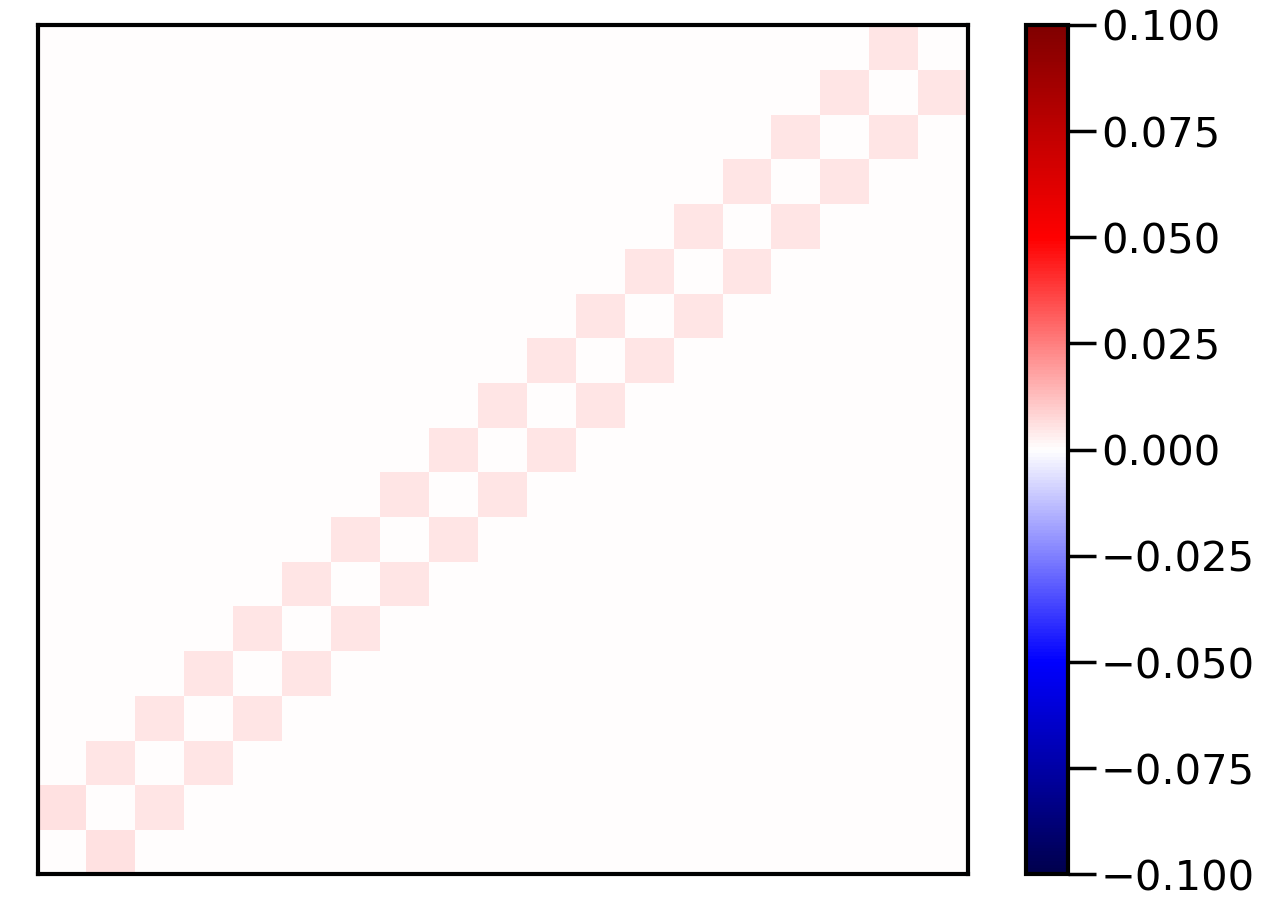

In [65]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cov_t['final_b'])
corrW-=np.diag(np.diag(corrW))
pcolor(corrW,vmin=-.1,vmax=.1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()



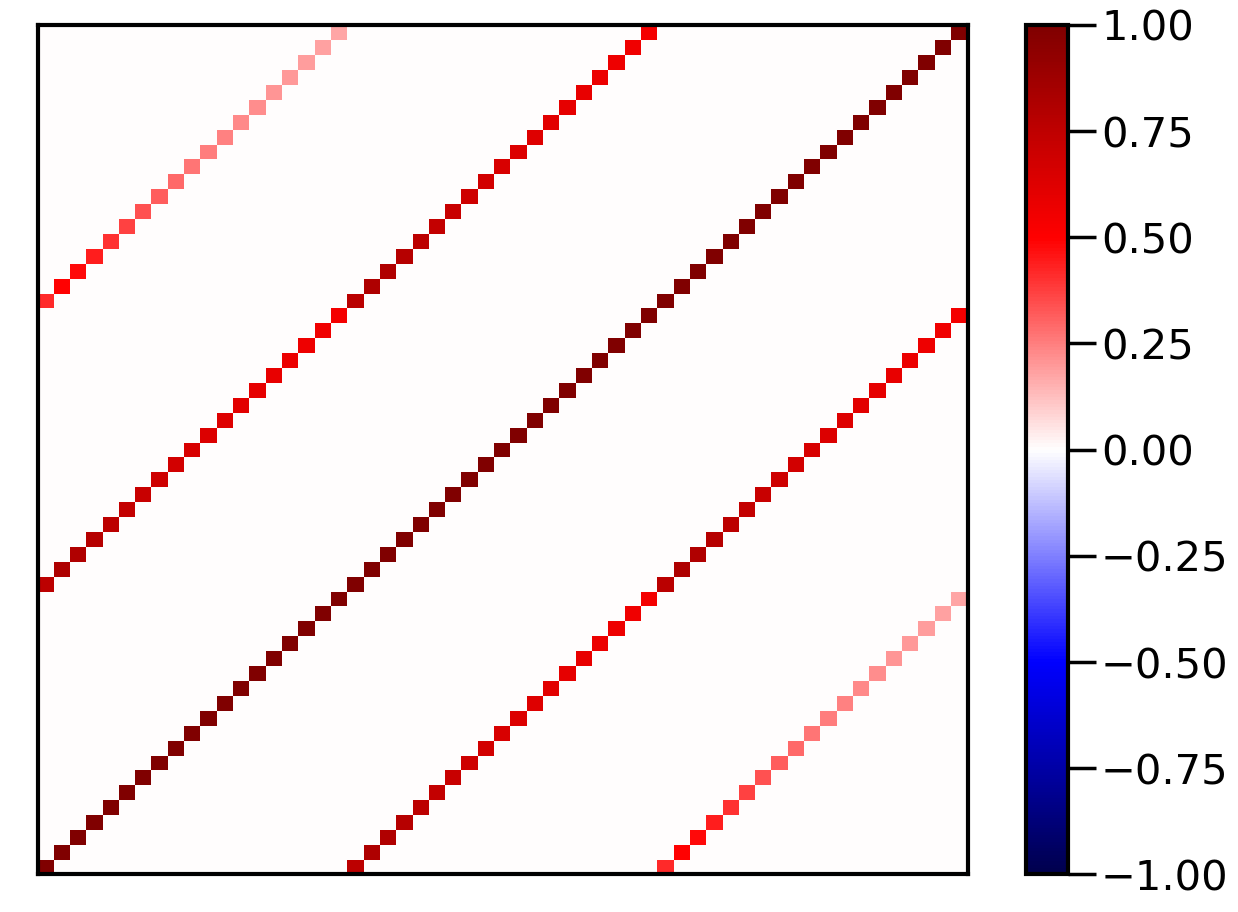

In [66]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
xticks([])
yticks([])
colorbar()
show()


In [67]:
XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['Om_w'],XI_W_L_NW.cov_utils.Om_W

(Delayed('getitem-772d535301a8d6a266931794541f6099'), 8.79645943005142)

TypeError: Delayed objects of unspecified length have no len()

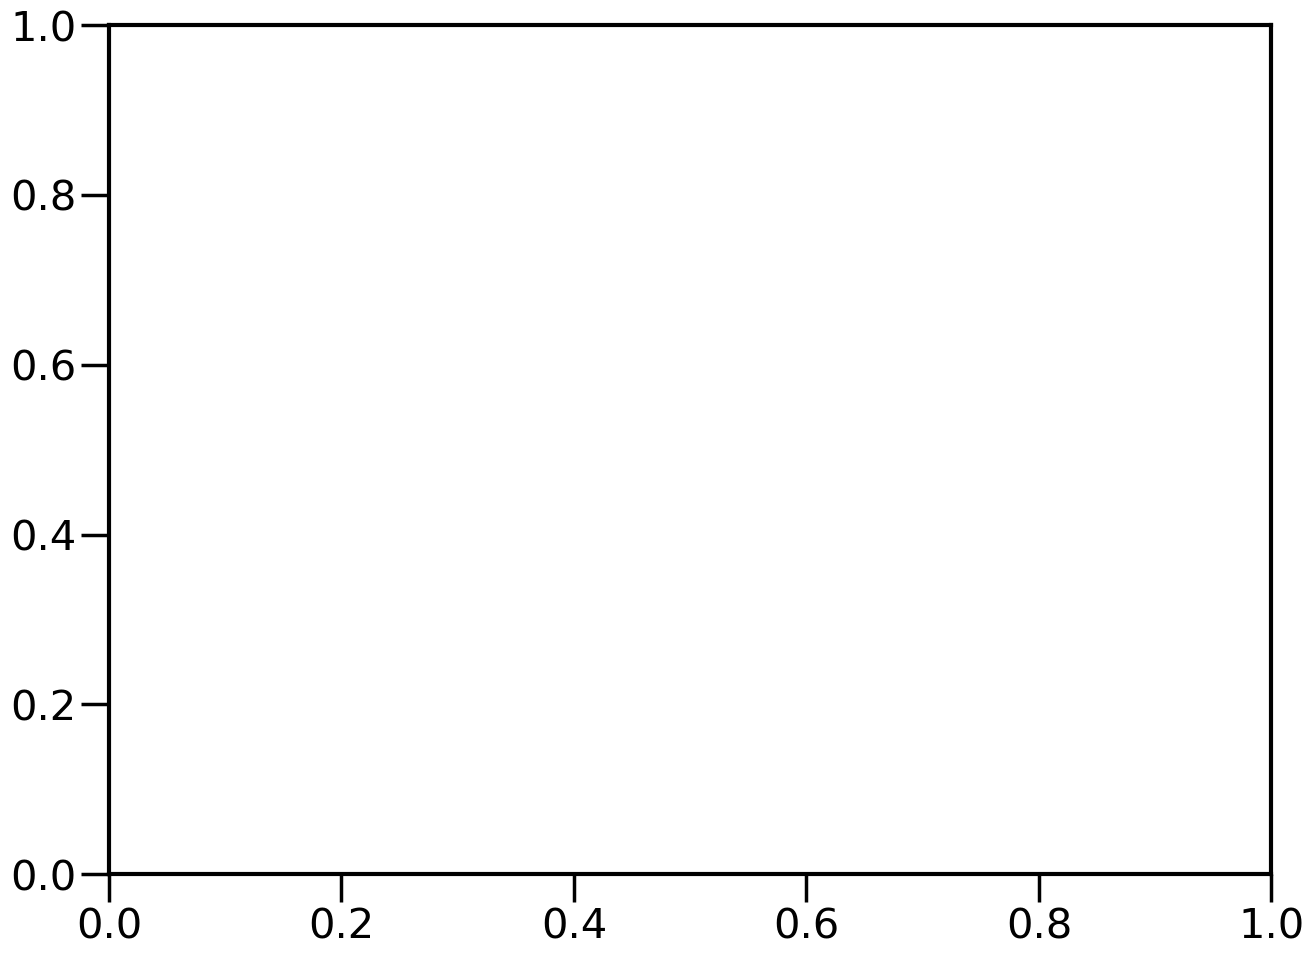

In [68]:
plot(XI_W_L.Win.Win['cov'][(corr_ll+corr_ll)][bi+bi]['mask_comb_cl'])
plot(XI_W_L_NW.cov_utils.Win)
yscale('log')

In [ ]:
XI_W_L.Win.Win['cov'][corr_ll+corr_ll][bi+bi]['mask_comb_cl']

In [ ]:
XI_W_L_NW.f_sky

In [ ]:
XI_W_L_NW.cov_utils.Win

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
linalg.cond(cl_L['cov']) #< 1/sys.float_info.epsilon

In [ ]:
N=np.linalg.norm(cl_L['cov'])
np.linalg.det(cl_L['cov']*5.e20)

In [ ]:
cov_inv=np.linalg.inv(cl_L['cov'])
cov_nw_inv=np.linalg.inv(cl_L_nw['cov'])
SN=cl_L['cl_b']@cov_inv@cl_L['cl_b']
SN_nw=cl_L_nw['cl_b']@cov_nw_inv@cl_L_nw['cl_b']
SN,SN_nw,SN/SN_nw

In [ ]:
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

In [ ]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

In [ ]:
XI_W_L.corrs

In [ ]:
XI_W_L.Win.Win.keys()

In [ ]:
f=1
xiW_L_nw_inv=np.linalg.inv(xiW_L_nw['cov']*f)
print ((np.dot(xiW_L_nw['xi'],np.dot(xiW_L_nw_inv,xiW_L_nw['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print ((np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
pcolor(xiW_L_nw['cov']/xiW_L['cov'])
colorbar()

In [ ]:
pcolor(xiW_L_nw_inv/cov_xiWL_inv)
colorbar()

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
R=np.diag(cl_L_nw['cov']/cl_L['cov'])
plot(R)

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-W')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corrNW=cc.corr_matrix(xiW_L_nw['cov'])
pcolor(corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
pcolor(corrW/corrNW-1,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
XI_W_L.cov_utils.gaussian_cov_norm_2D

In [ ]:
np.diag(xiW_L_nw['cov'])/np.diag(xiW_L['cov'])

In [ ]:
5.25/1.93

In [ ]:
x=np.array([1,0.5,0.1,0.3,0.7])
plot(x,[1,1.93,5.25,2.85,1.37],'bo')
plot(x,1./x,'ro')
yscale('log')
xscale('log')

In [ ]:
xiW_L_nw['cov']/xiW_L['cov']

In [ ]:
xiW_L_nw['xi']/xiW_L['xi']